# Data Visualisation

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import max_error, mean_absolute_error as mae, median_absolute_error as medae, mean_squared_log_error as msle
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv('bank_cleaned.csv')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,other,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,other,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,other,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,other,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,other,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,other,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [3]:
listItem = []
for col in df.columns :
  listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum() / len(df[col])) * 100,2),
                   df[col].nunique(), list(df[col].unique()[:2])]);

dfDesc = pd.DataFrame(columns = ['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'], data = listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,int64,0,0.0,76,"[59, 56]"
1,job,object,0,0.0,12,"[admin., technician]"
2,marital,object,0,0.0,3,"[married, single]"
3,education,object,0,0.0,4,"[secondary, tertiary]"
4,default,object,0,0.0,2,"[no, yes]"
5,balance,int64,0,0.0,3805,"[2343, 45]"
6,housing,object,0,0.0,2,"[yes, no]"
7,loan,object,0,0.0,2,"[no, yes]"
8,contact,object,0,0.0,3,"[other, cellular]"
9,day,int64,0,0.0,31,"[5, 6]"


## Know the Balance of your target

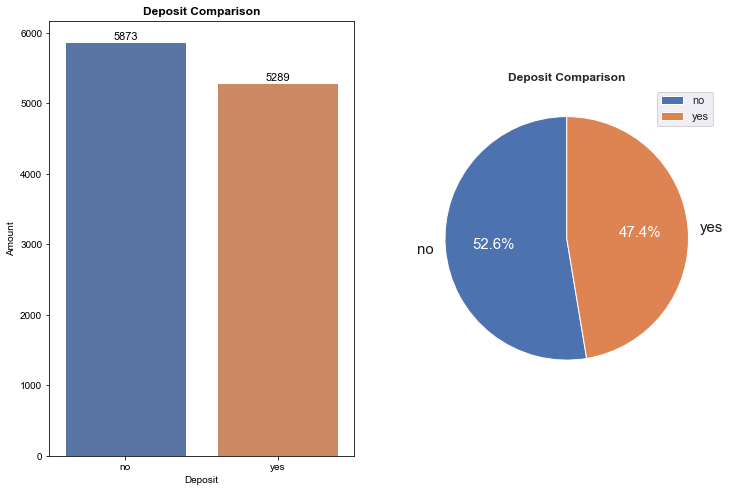

In [4]:
val = df.loc[:,"deposit"].value_counts()
ind = df["deposit"].value_counts().sort_index().index

plt.figure(figsize=[12,8])

plt.subplot(121)
plt.title("Deposit Comparison", size= 12, fontweight="bold")
sns.set(style="darkgrid")
mark = sns.barplot(x= ind, y= val, data= df, ci=None)
for p in mark.patches:
             mark.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=11, color="black", rotation=0, xytext=(0, 5),
                 textcoords="offset points")
plt.xlabel("Deposit")
plt.ylabel("Amount")

plt.subplot(122)
x,y,z = plt.pie (val, labels=ind, startangle=90,
        shadow= False,textprops={"size":15, "color":"k"},
        autopct = "%1.1f%%", radius=1)
plt.title("Deposit Comparison", size= 12, fontweight="bold")
for i in z:
    i.set_color("white")
plt.legend(ind)

        
plt.show()

In [5]:
dfCat = dfDesc[dfDesc['dataType'] == 'object']['dataFeatures'].tolist()
dfNum = dfDesc[dfDesc['dataType'] == 'int64']['dataFeatures'].tolist()
dfNum

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [6]:
dtdep = df[df["deposit"] == "yes"]
dtnotdep = df[df["deposit"] == "no"]
df['depositbin'] = df['deposit'].replace({'yes' : 1, 'no' : 0})

## Numerical Data

In [7]:
# Getting insight from Numerical data

In [8]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

### Age x Deposit

In [9]:
mx = df["age"].max()
mn = df["age"].min()
ranges = np.arange(mn, mx + round((mx-mn)/10), round((mx-mn)/10))

age = pd.DataFrame()
age["notdeposit"] = round(dtnotdep["deposit"].groupby(pd.cut(dtnotdep["age"], ranges)).count())
age["deposit"] = round(dtdep["deposit"].groupby(pd.cut(dtdep["age"], ranges)).count())
age["%deposit"] = round((age["deposit"] * 100/(age["notdeposit"] + age["deposit"])), 2)
age.T

age,"(18, 26]","(26, 34]","(34, 42]","(42, 50]","(50, 58]","(58, 66]","(66, 74]","(74, 82]","(82, 90]","(90, 98]"
notdeposit,230.00,1699.00,1671.00,1114.00,882.00,203.00,34.00,32.0,7.00,0.0
deposit,447.00,1526.00,1208.00,788.00,625.00,392.00,164.00,103.0,24.00,5.0
%deposit,66.03,47.32,41.96,41.43,41.47,65.88,82.83,76.3,77.42,100.0


In [10]:
age_cor = correlation_ratio(df['age'], df['depositbin'])

### Balance x Deposit

In [11]:
mx = df["balance"].max()
mn = df["balance"].min()
ranges = np.arange(mn, mx + round((mx-mn)/10), round((mx-mn)/10))

balance = pd.DataFrame()
balance["notdeposit"] = round(dtnotdep["deposit"].groupby(pd.cut(dtnotdep["balance"], ranges)).count())
balance["deposit"] = round(dtdep["deposit"].groupby(pd.cut(dtdep["balance"], ranges)).count())
balance["%deposit"] = round((balance["deposit"] * 100/(balance["notdeposit"] + balance["deposit"])), 2)
balance.T

balance,"(-6847, 1958]","(1958, 10763]","(10763, 19568]","(19568, 28373]","(28373, 37178]","(37178, 45983]","(45983, 54788]","(54788, 63593]","(63593, 72398]","(72398, 81203]","(81203, 90008]"
notdeposit,4824.00,966.00,54.00,19.00,6.0,0.0,1.00,1.0,1.0,0.0,0.0
deposit,3848.00,1330.00,82.00,18.00,6.0,1.0,2.00,0.0,0.0,0.0,2.0
%deposit,44.37,57.93,60.29,48.65,50.0,100.0,66.67,0.0,0.0,NaN,100.0


In [12]:
balance_cor = correlation_ratio(df['balance'], df['depositbin'])

### Day x Deposit

In [13]:
mx = df["day"].max()
mn = df["day"].min()
ranges = np.arange(mn, mx + round((mx-mn)/10), round((mx-mn)/10))

day = pd.DataFrame()
day["notdeposit"] = round(dtnotdep["deposit"].groupby(pd.cut(dtnotdep["day"], ranges)).count())
day["deposit"] = round(dtdep["deposit"].groupby(pd.cut(dtdep["day"], ranges)).count())
day["%deposit"] = round((day["deposit"] * 100/(day["notdeposit"] + day["deposit"])), 2)
day.T

day,"(1, 4]","(4, 7]","(7, 10]","(10, 13]","(13, 16]","(16, 19]","(19, 22]","(22, 25]","(25, 28]","(28, 31]"
notdeposit,452.00,753.00,445.00,605.0,658.00,817.00,744.00,270.00,537.00,560.00
deposit,590.00,553.00,501.00,666.0,640.00,526.00,547.00,321.00,409.00,446.00
%deposit,56.62,42.34,52.96,52.4,49.31,39.17,42.37,54.31,43.23,44.33


In [14]:
day_cor = correlation_ratio(df['day'], df['depositbin'])

### Duration x Deposit

In [15]:
mx = df["duration"].max()
mn = df["duration"].min()
ranges = np.arange(mn, mx + round((mx-mn)/10), round((mx-mn)/10))

duration = pd.DataFrame()
duration["notdeposit"] = round(dtnotdep["deposit"].groupby(pd.cut(dtnotdep["duration"], ranges)).count())
duration["deposit"] = round(dtdep["deposit"].groupby(pd.cut(dtdep["duration"], ranges)).count())
duration["%deposit"] = round((duration["deposit"] * 100/(duration["notdeposit"] + duration["deposit"])), 2)
duration.T

duration,"(2, 390]","(390, 778]","(778, 1166]","(1166, 1554]","(1554, 1942]","(1942, 2330]","(2330, 2718]","(2718, 3106]","(3106, 3494]","(3494, 3882]"
notdeposit,5081.00,640.0,112.0,31.00,5.00,2.00,0.0,0.0,1.00,0.0
deposit,2429.00,1704.0,777.0,262.00,78.00,22.00,8.0,6.0,2.00,1.0
%deposit,32.34,72.7,87.4,89.42,93.98,91.67,100.0,100.0,66.67,100.0


In [16]:
duration_cor = correlation_ratio(df['duration'], df['depositbin'])

### Campaign x Deposit

In [17]:
mx = df["campaign"].max()
mn = df["campaign"].min()
ranges = np.arange(mn, mx + round((mx-mn)/10), round((mx-mn)/10))

campaign = pd.DataFrame()
campaign["notdeposit"] = round(dtnotdep["deposit"].groupby(pd.cut(dtnotdep["campaign"], ranges)).count())
campaign["deposit"] = round(dtdep["deposit"].groupby(pd.cut(dtdep["campaign"], ranges)).count())
campaign["%deposit"] = round((campaign["deposit"] * 100/(campaign["notdeposit"] + campaign["deposit"])), 2)
campaign.T

campaign,"(1, 7]","(7, 13]","(13, 19]","(19, 25]","(25, 31]","(31, 37]","(37, 43]","(43, 49]","(49, 55]","(55, 61]","(61, 67]"
notdeposit,3288.00,258.0,48.0,25.00,11.00,2.00,3.0,0.0,0.0,0.0,1.0
deposit,2614.00,93.0,16.0,3.00,1.00,1.00,0.0,0.0,0.0,0.0,0.0
%deposit,44.29,26.5,25.0,10.71,8.33,33.33,0.0,NaN,NaN,NaN,0.0


In [18]:
camp_cor = correlation_ratio(df['campaign'], df['depositbin'])

### pDays x Deposit

In [19]:
mx = df["pdays"].max()
mn = df["pdays"].min()
ranges = np.arange(mn, mx + round((mx-mn)/10), round((mx-mn)/10))

pdays = pd.DataFrame()
pdays["notdeposit"] = round(dtnotdep["deposit"].groupby(pd.cut(dtnotdep["pdays"], ranges)).count())
pdays["deposit"] = round(dtdep["deposit"].groupby(pd.cut(dtdep["pdays"], ranges)).count())
pdays["%deposit"] = round((pdays["deposit"] * 100/(pdays["notdeposit"] + pdays["deposit"])), 2)
pdays.T

pdays,"(-1, 85]","(85, 171]","(171, 257]","(257, 343]","(343, 429]","(429, 515]","(515, 601]","(601, 687]","(687, 773]","(773, 859]"
notdeposit,62.00,239.00,229.00,218.00,169.00,5.00,3.0,1.00,4.00,3.0
deposit,151.00,703.00,588.00,206.00,166.00,51.00,21.0,5.00,5.00,9.0
%deposit,70.89,74.63,71.97,48.58,49.55,91.07,87.5,83.33,55.56,75.0


In [20]:
pday_cor = correlation_ratio(df['pdays'], df['depositbin'])

### Previous x Deposit

In [21]:
mx = df["previous"].max()
mn = df["previous"].min()
ranges = np.arange(mn, mx + round((mx-mn)/10), round((mx-mn)/10))

previous = pd.DataFrame()
previous["notdeposit"] = round(dtnotdep["deposit"].groupby(pd.cut(dtnotdep["previous"], ranges)).count())
previous["deposit"] = round(dtdep["deposit"].groupby(pd.cut(dtdep["previous"], ranges)).count())
previous["%deposit"] = round((previous["deposit"] * 100/(previous["notdeposit"] + previous["deposit"])), 2)
previous.T

previous,"(0, 6]","(6, 12]","(12, 18]","(18, 24]","(24, 30]","(30, 36]","(36, 42]","(42, 48]","(48, 54]","(54, 60]"
notdeposit,833.00,72.0,18.0,4.0,3.0,0.0,3.0,0.0,0.0,0.0
deposit,1708.00,168.0,18.0,6.0,3.0,0.0,0.0,0.0,0.0,2.0
%deposit,67.22,70.0,50.0,60.0,50.0,NaN,0.0,NaN,NaN,100.0


In [22]:
prev_cor = correlation_ratio(df['previous'], df['depositbin'])

### Checking Outliers

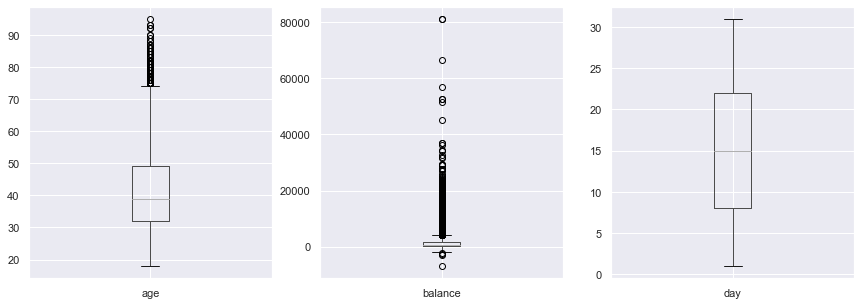

In [23]:
# checking outliers
col = ['age', 'balance', 'day']

plt.figure(figsize=(20,5))
for i in range(len(col)):
    plt.subplot(1,4,i+1)
    df.boxplot(col[i])

In [24]:
col = ['age', 'balance', 'day']

def outliers (df,col_name):
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3-Q1 #Interquartile range
    Low = Q1 - 1.5 * IQR
    High = Q3 + 1.5 * IQR
    Low_bound  = Q1 - (1.5*IQR)
    Number = df[(df[i] > High + (df[i] < Low))][i].count()
    Perc = round(Number * 100 / len(df), 2)
    Up_bound = Q3 + (1.5*IQR)
    print(col_name)
    print(f'Lower Bound : {Low_bound}'+'\n'
          f'Upper Bound : {Up_bound}'+'\n'
          f'percentage : {Perc}')
    print('-'*30)
    
for i in col:
    outliers(df,i)

age
Lower Bound : 6.5
Upper Bound : 74.5
percentage : 1.53
------------------------------
balance
Lower Bound : -2257.0
Upper Bound : 4087.0
percentage : 9.42
------------------------------
day
Lower Bound : -13.0
Upper Bound : 43.0
percentage : 0.0
------------------------------


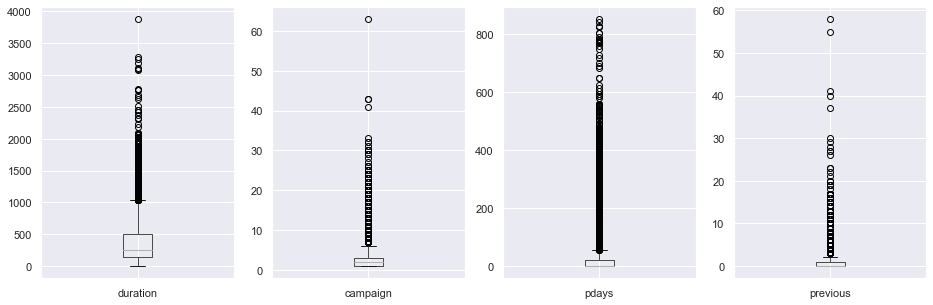

In [25]:
col = ['duration', 'campaign', 'pdays', 'previous']

plt.figure(figsize=(20,5))
for i in range(len(col)):
    plt.subplot(1,5,i+1)
    df.boxplot(col[i])

In [26]:
col = ['duration', 'campaign', 'pdays', 'previous']

def outliers (df,col_name):
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3-Q1 #Interquartile range
    Low = Q1 - 1.5 * IQR
    High = Q3 + 1.5 * IQR
    Low_bound  = Q1 - (1.5*IQR)
    Number = df[(df[i] > High + (df[i] < Low))][i].count()
    Perc = round(Number * 100 / len(df), 2)
    Up_bound = Q3 + (1.5*IQR)
    print(col_name)
    print(f'Lower Bound : {Low_bound}'+'\n'
          f'Upper Bound : {Up_bound}'+'\n'
          f'percentage : {Perc}')
    print('-'*30)
    
for i in col:
    outliers(df,i)

duration
Lower Bound : -399.0
Upper Bound : 1033.0
percentage : 5.7
------------------------------
campaign
Lower Bound : -2.0
Upper Bound : 6.0
percentage : 5.38
------------------------------
pdays
Lower Bound : -33.625
Upper Bound : 53.375
percentage : 24.64
------------------------------
previous
Lower Bound : -1.5
Upper Bound : 2.5
percentage : 11.27
------------------------------


### Correlation

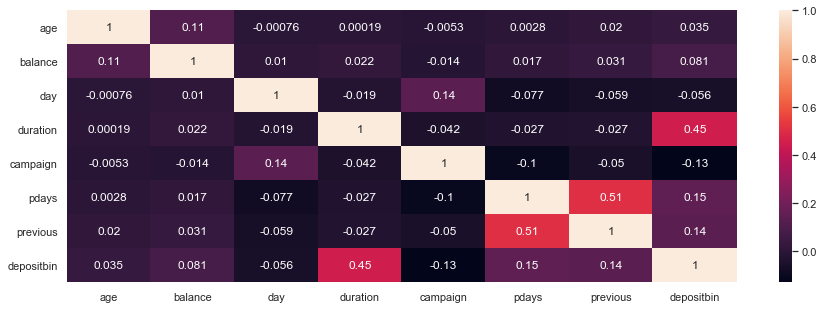

In [27]:
plt.figure(figsize = (15, 5))
sns.heatmap(df.corr(method = 'pearson'), annot = True)

plt.show()

In [28]:
df.corr()['depositbin'].sort_values(ascending=False)

depositbin    1.000000
duration      0.451919
pdays         0.151593
previous      0.139867
balance       0.081129
age           0.034901
day          -0.056326
campaign     -0.128081
Name: depositbin, dtype: float64

In [29]:
print(f'Correlation between Age and Deposit : {age_cor}'+'\n'
      f'Correlation between Balance and Deposit : {balance_cor}'+'\n'
      f'Correlation between Day and Deposit : {day_cor}'+'\n'
      f'Correlation between Duration and Deposit : {duration_cor}'+'\n'
      f'Correlation between Campaign and Deposit : {camp_cor}'+'\n'
      f'Correlation between pDays and Deposit : {pday_cor}'+'\n'
      f'Correlation between Previous and Deposit : {prev_cor}')

Correlation between Age and Deposit : 0.22826238057205225
Correlation between Balance and Deposit : 0.639555667374093
Correlation between Day and Deposit : 0.18055829599304973
Correlation between Duration and Deposit : 0.5917987322528402
Correlation between Campaign and Deposit : 0.14723951736593915
Correlation between pDays and Deposit : 0.3474210793035925
Correlation between Previous and Deposit : 0.23921888969029628


In [30]:
# from exploration numerical data, we found that pdays and previous have outliers's percentage much bigger
# than the rest, so i would like to drop these two features.
# also i would like to drop days, because the average of percentage for four days have not any impact to people who will apply to deposit
# and days in this dataset is the last day in "one month" of people get contacted.
# and also for campaign since the correlation is low, 

## Categorical Data

In [31]:
# Comparing categorical data
dtdep = df[df["deposit"] == "yes"]
dtnotdep = df[df["deposit"] == "no"]

In [32]:
dfCat

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'deposit']

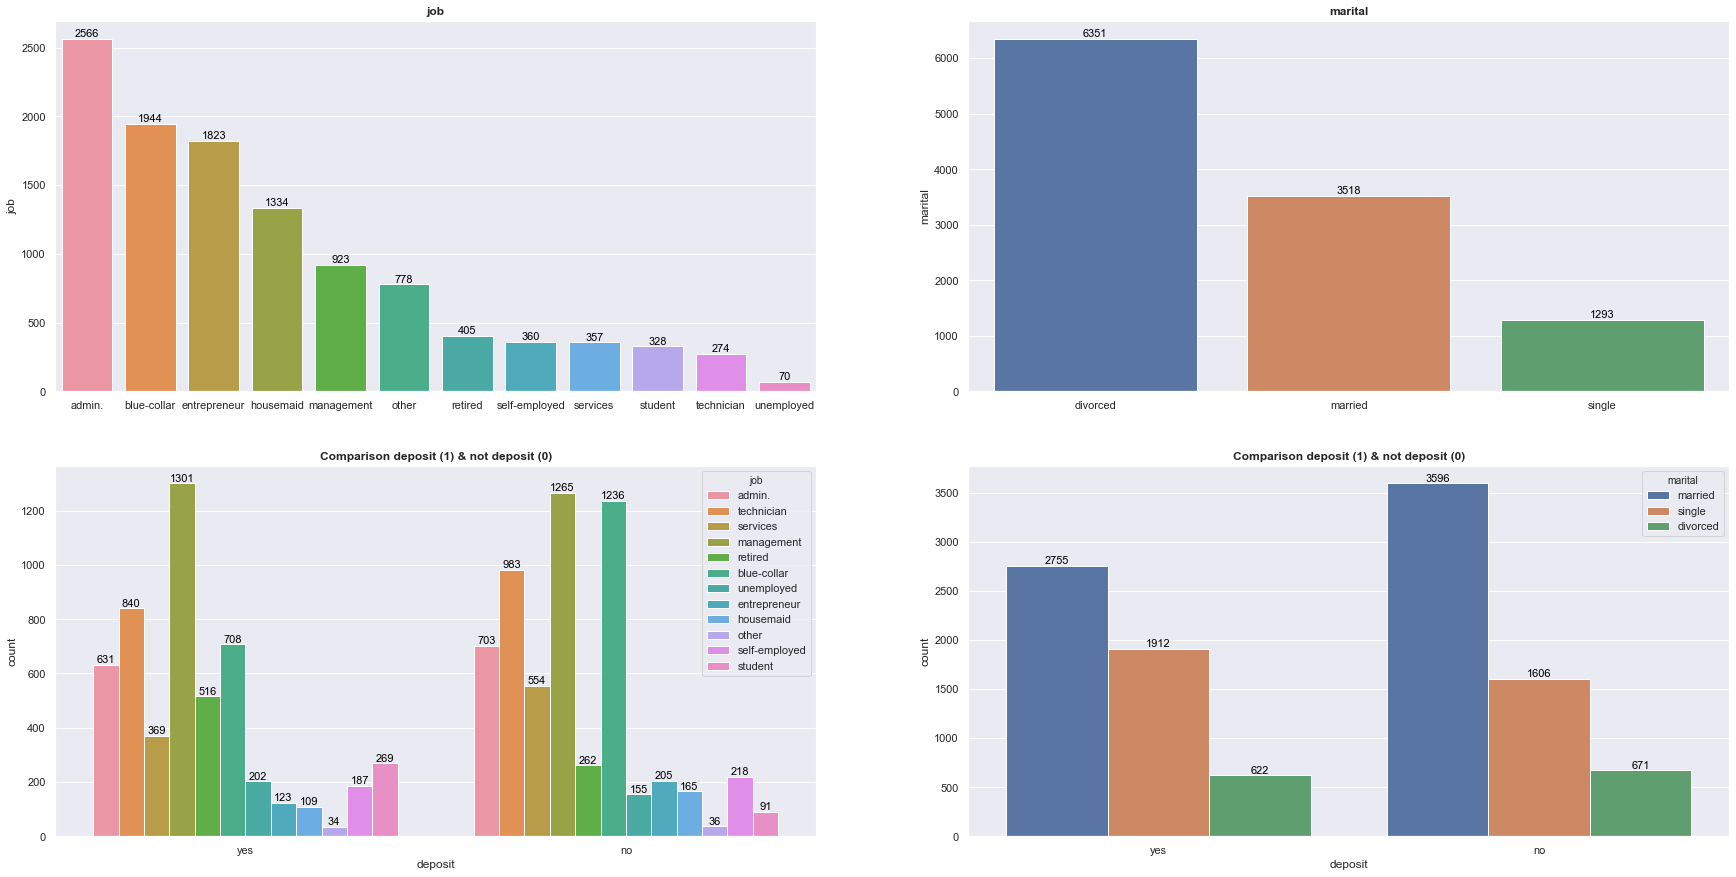

In [33]:
column = ["job", "marital"]

sns.set(style = "darkgrid")
fig = plt.figure(figsize = (30,15))

for i in range(len(column)):    
    val = df.loc[:,column[i]].value_counts()
    ind = df[column[i]].value_counts().sort_index().index
    
    ax1 = fig.add_subplot(2, 2, i+1)
    ax1.set_title(column[i], fontweight="bold")

    ax2 = fig.add_subplot(2, 2, 3+i)
    ax2.set_title("Comparison deposit (1) & not deposit (0)", fontweight="bold")

    mark1 = sns.barplot(x = ind, y = val, ax= ax1 )
    for p in mark1.patches:
                 mark1.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha="center", va="center", fontsize=11, color="black", rotation=0, xytext=(0, 5),
                     textcoords="offset points")
    mark2 = sns.countplot(x = "deposit", hue = column[i], data = df, ax = ax2)
    for p in mark2.patches:
                 mark2.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha="center", va="center", fontsize=11, color="black", rotation=0, xytext=(0, 5),
                     textcoords="offset points")

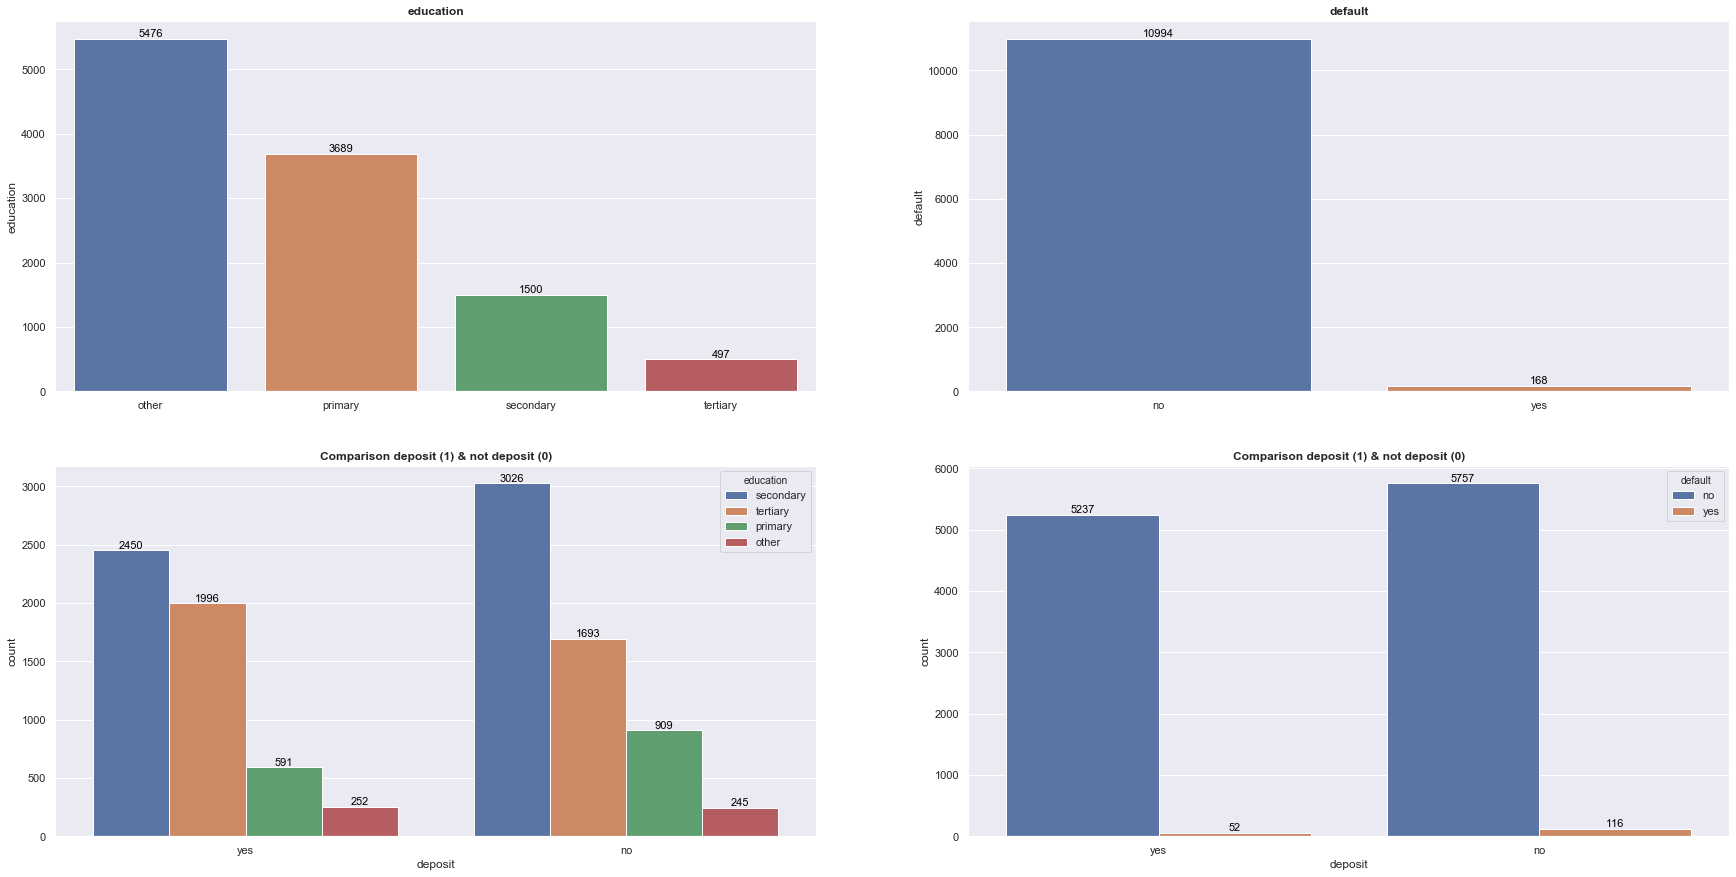

In [34]:
column = ["education", "default"]

sns.set(style = "darkgrid")
fig = plt.figure(figsize = (30,15))

for i in range(len(column)):    
    val = df.loc[:,column[i]].value_counts()
    ind = df[column[i]].value_counts().sort_index().index
    
    ax1 = fig.add_subplot(2, 2, i+1)
    ax1.set_title(column[i], fontweight="bold")

    ax2 = fig.add_subplot(2, 2, 3+i)
    ax2.set_title("Comparison deposit (1) & not deposit (0)", fontweight="bold")

    mark1 = sns.barplot(x = ind, y = val, ax= ax1 )
    for p in mark1.patches:
                 mark1.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha="center", va="center", fontsize=11, color="black", rotation=0, xytext=(0, 5),
                     textcoords="offset points")
    mark2 = sns.countplot(x = "deposit", hue = column[i], data = df, ax = ax2)
    for p in mark2.patches:
                 mark2.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha="center", va="center", fontsize=11, color="black", rotation=0, xytext=(0, 5),
                     textcoords="offset points")

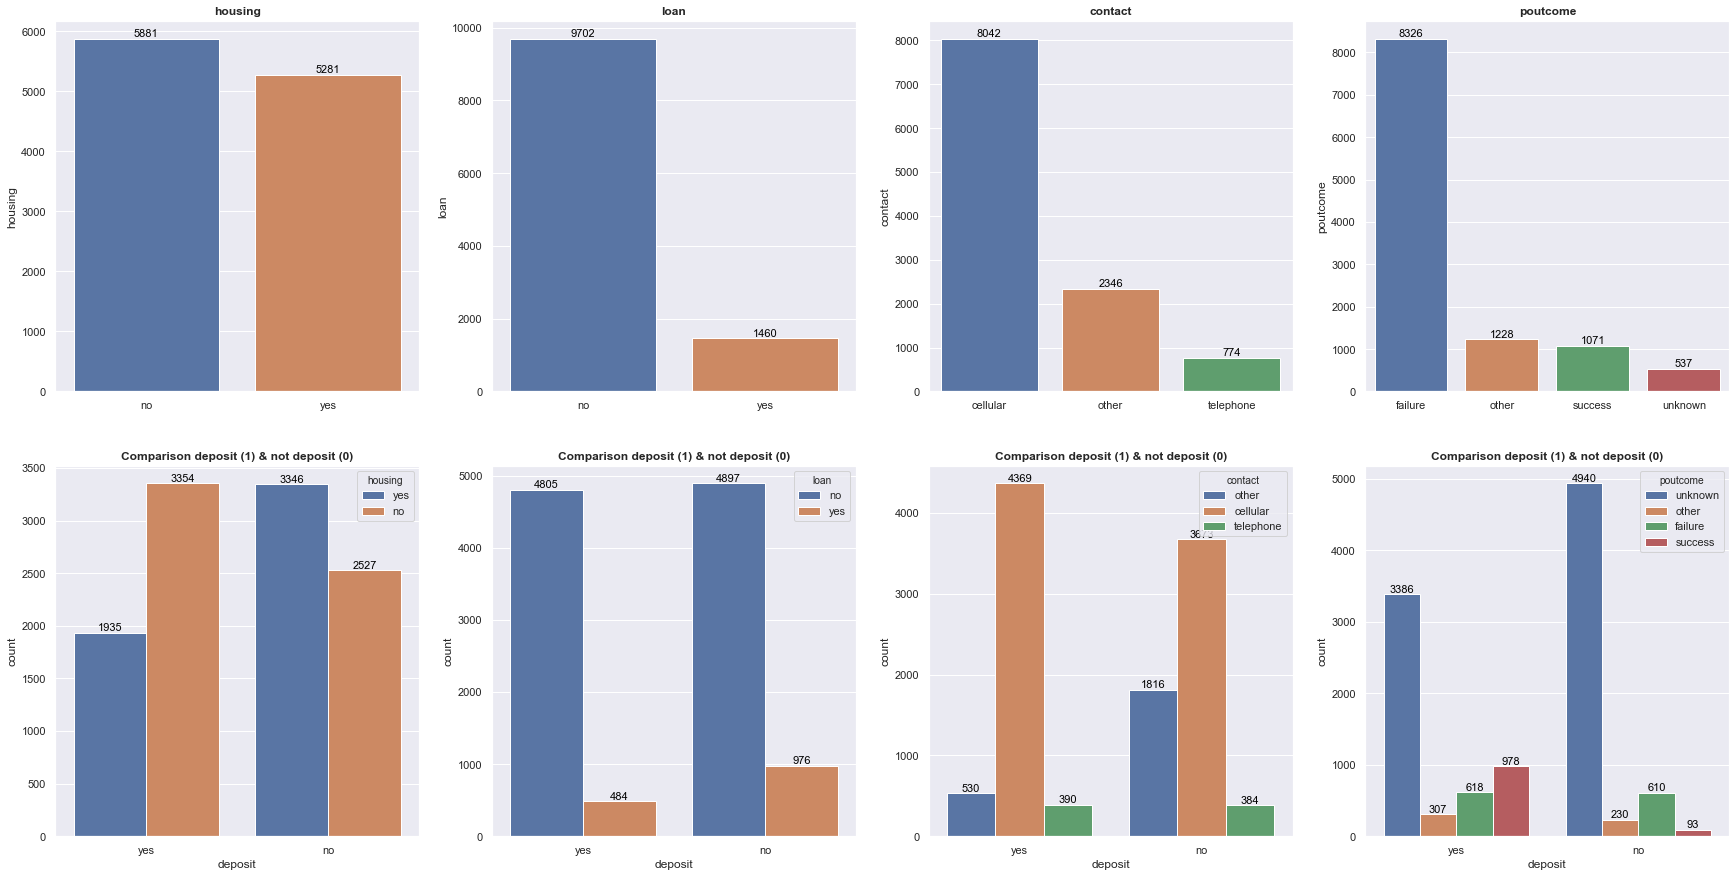

In [35]:
column = ["housing", "loan", "contact",  "poutcome"]

sns.set(style = "darkgrid")
fig = plt.figure(figsize = (30,15))

for i in range(len(column)):    
    val = df.loc[:,column[i]].value_counts()
    ind = df[column[i]].value_counts().sort_index().index
    
    ax1 = fig.add_subplot(2, 4, i+1)
    ax1.set_title(column[i], fontweight="bold")

    ax2 = fig.add_subplot(2, 4, 5+i)
    ax2.set_title("Comparison deposit (1) & not deposit (0)", fontweight="bold")

    mark1 = sns.barplot(x = ind, y = val, ax= ax1 )
    for p in mark1.patches:
                 mark1.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha="center", va="center", fontsize=11, color="black", rotation=0, xytext=(0, 5),
                     textcoords="offset points")
    mark2 = sns.countplot(x = "deposit", hue = column[i], data = df, ax = ax2)
    for p in mark2.patches:
                 mark2.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha="center", va="center", fontsize=11, color="black", rotation=0, xytext=(0, 5),
                     textcoords="offset points")

### Job x Deposit

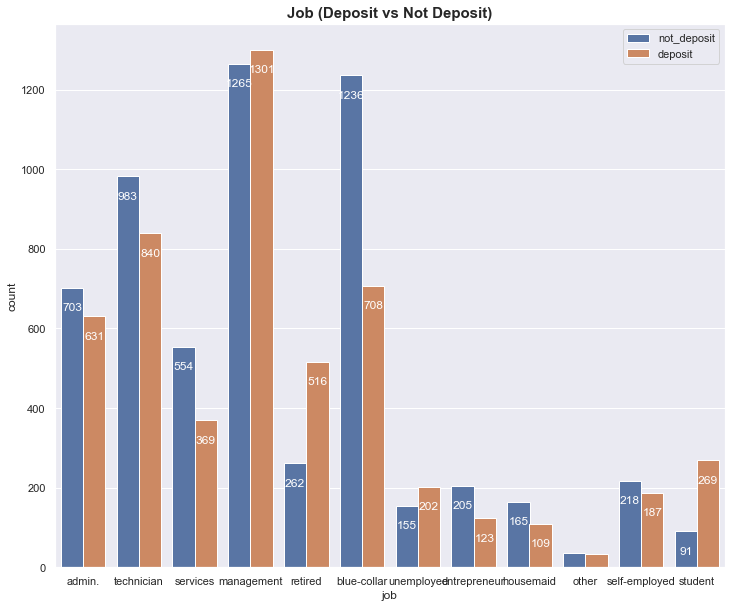

In [36]:
fig5 = plt.figure(figsize=(12,10))
plt.title('Job (Deposit vs Not Deposit)', fontsize=15, fontweight='bold')

ax_d = sns.countplot(df['job'], hue=df['depositbin'])
for d in ax_d.patches:
    ax_d.annotate(format(d.get_height(), '.0f'), (d.get_x() + d.get_width() / 2., d.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, -20), fontsize=12, color='white', textcoords = 'offset points')
plt.legend(['not_deposit', 'deposit'])
plt.show()

In [37]:
feat = "job"

valdep = dtdep.loc[:,feat].value_counts()
valnotdep = dtnotdep.loc[:, feat].value_counts()

job = pd.DataFrame()
job["notDeposit"] = valnotdep
job["Deposit"] = valdep
job["%Deposit"] = round((valdep * 100 / (valdep + valnotdep)), 2)
job

,notDeposit,Deposit,%Deposit
management,1265,1301,50.70
blue-collar,1236,708,36.42
technician,983,840,46.08
admin.,703,631,47.30
services,554,369,39.98
retired,262,516,66.32
self-employed,218,187,46.17
entrepreneur,205,123,37.50
housemaid,165,109,39.78
unemployed,155,202,56.58


In [38]:
job_cor = correlation_ratio(df['job'], df['depositbin'])

### Marital Status x Deposit

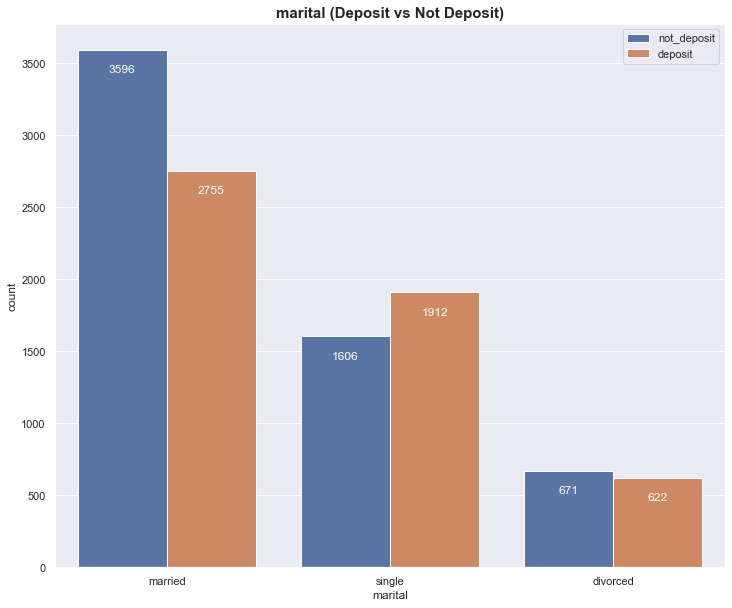

In [39]:
fig5 = plt.figure(figsize=(12,10))
plt.title('marital (Deposit vs Not Deposit)', fontsize=15, fontweight='bold')

ax_d = sns.countplot(df['marital'], hue=df['depositbin'])
for d in ax_d.patches:
    ax_d.annotate(format(d.get_height(), '.0f'), (d.get_x() + d.get_width() / 2., d.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, -20), fontsize=12, color='white', textcoords = 'offset points')
plt.legend(['not_deposit', 'deposit'])
plt.show()

In [40]:
feat = "marital"

valdep = dtdep.loc[:,feat].value_counts()
valnotdep = dtnotdep.loc[:, feat].value_counts()

marital = pd.DataFrame()
marital["notDeposit"] = valnotdep
marital["Deposit"] = valdep
marital["%Deposit"] = round((valdep * 100 / (valdep + valnotdep)), 2)
marital

,notDeposit,Deposit,%Deposit
married,3596,2755,43.38
single,1606,1912,54.35
divorced,671,622,48.11


In [41]:
mar_cor = correlation_ratio(df['marital'], df['depositbin'])

### Education x Deposit

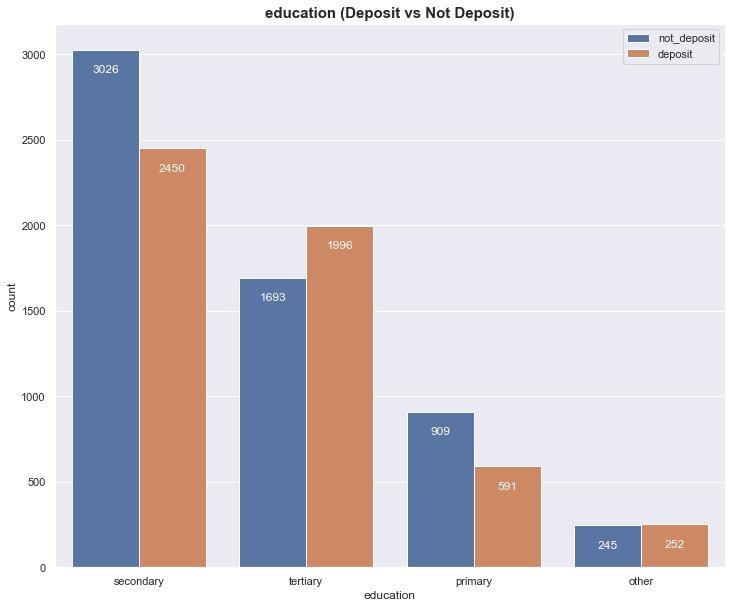

In [42]:
fig5 = plt.figure(figsize=(12,10))
plt.title('education (Deposit vs Not Deposit)', fontsize=15, fontweight='bold')

ax_d = sns.countplot(df['education'], hue=df['depositbin'])
for d in ax_d.patches:
    ax_d.annotate(format(d.get_height(), '.0f'), (d.get_x() + d.get_width() / 2., d.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, -20), fontsize=12, color='white', textcoords = 'offset points')
plt.legend(['not_deposit', 'deposit'])
plt.show()

In [43]:
feat = "education"

valdep = dtdep.loc[:,feat].value_counts()
valnotdep = dtnotdep.loc[:, feat].value_counts()

education = pd.DataFrame()
education["notDeposit"] = valnotdep
education["Deposit"] = valdep
education["%Deposit"] = round((valdep * 100 / (valdep + valnotdep)), 2)
education

,notDeposit,Deposit,%Deposit
secondary,3026,2450,44.74
tertiary,1693,1996,54.11
primary,909,591,39.40
other,245,252,50.70


In [44]:
edu_cor = correlation_ratio(df['education'], df['depositbin'])

### Default x Deposit

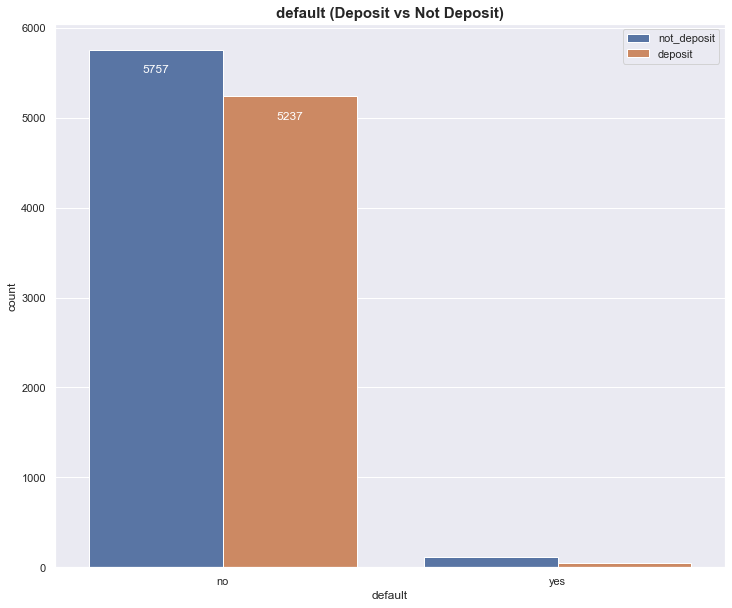

In [45]:
fig5 = plt.figure(figsize=(12,10))
plt.title('default (Deposit vs Not Deposit)', fontsize=15, fontweight='bold')

ax_d = sns.countplot(df['default'], hue=df['depositbin'])
for d in ax_d.patches:
    ax_d.annotate(format(d.get_height(), '.0f'), (d.get_x() + d.get_width() / 2., d.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, -20), fontsize=12, color='white', textcoords = 'offset points')
plt.legend(['not_deposit', 'deposit'])
plt.show()

In [46]:
feat = "default"

valdep = dtdep.loc[:,feat].value_counts()
valnotdep = dtnotdep.loc[:, feat].value_counts()

default = pd.DataFrame()
default["notDeposit"] = valnotdep
default["Deposit"] = valdep
default["%Deposit"] = round((valdep * 100 / (valdep + valnotdep)), 2)
default

,notDeposit,Deposit,%Deposit
no,5757,5237,47.64
yes,116,52,30.95


In [47]:
defa_cor = correlation_ratio(df['default'], df['depositbin'])

### Housing x Default

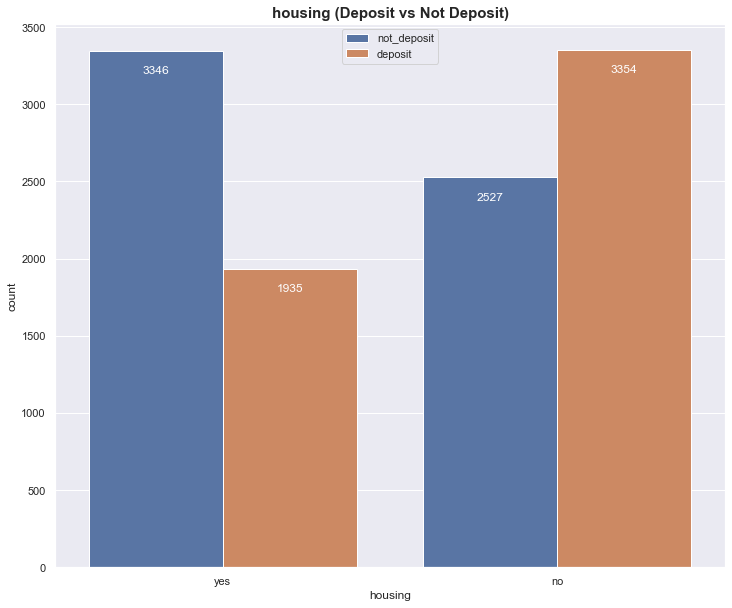

In [48]:
fig5 = plt.figure(figsize=(12,10))
plt.title('housing (Deposit vs Not Deposit)', fontsize=15, fontweight='bold')

ax_d = sns.countplot(df['housing'], hue=df['depositbin'])
for d in ax_d.patches:
    ax_d.annotate(format(d.get_height(), '.0f'), (d.get_x() + d.get_width() / 2., d.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, -20), fontsize=12, color='white', textcoords = 'offset points')
plt.legend(['not_deposit', 'deposit'])
plt.show()

In [49]:
feat = "housing"

valdep = dtdep.loc[:,feat].value_counts()
valnotdep = dtnotdep.loc[:, feat].value_counts()

housing = pd.DataFrame()
housing["notDeposit"] = valnotdep
housing["Deposit"] = valdep
housing["%Deposit"] = round((valdep * 100 / (valdep + valnotdep)), 2)
housing

,notDeposit,Deposit,%Deposit
yes,3346,1935,36.64
no,2527,3354,57.03


In [50]:
housing_cor = correlation_ratio(df['housing'], df['depositbin'])

### Loan x Default

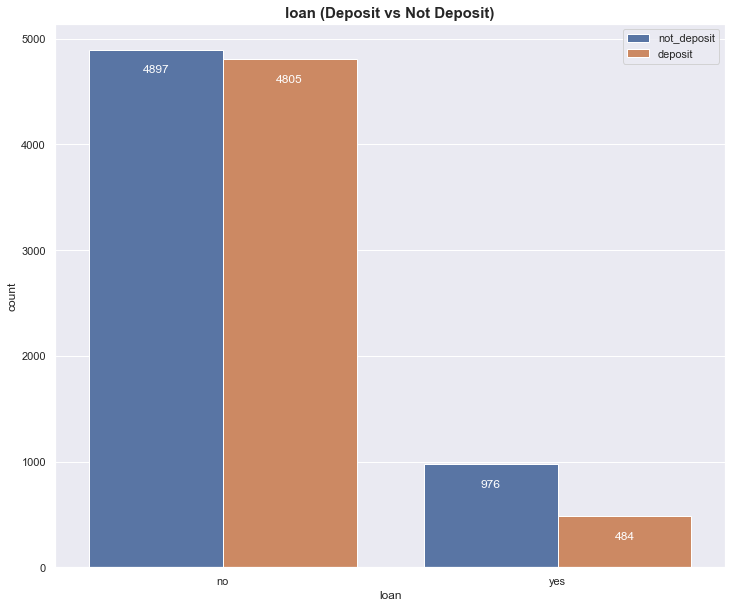

In [51]:
fig5 = plt.figure(figsize=(12,10))
plt.title('loan (Deposit vs Not Deposit)', fontsize=15, fontweight='bold')

ax_d = sns.countplot(df['loan'], hue=df['depositbin'])
for d in ax_d.patches:
    ax_d.annotate(format(d.get_height(), '.0f'), (d.get_x() + d.get_width() / 2., d.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, -20), fontsize=12, color='white', textcoords = 'offset points')
plt.legend(['not_deposit', 'deposit'])
plt.show()

In [52]:
feat = "loan"

valdep = dtdep.loc[:,feat].value_counts()
valnotdep = dtnotdep.loc[:, feat].value_counts()

loan = pd.DataFrame()
loan["notDeposit"] = valnotdep
loan["Deposit"] = valdep
loan["%Deposit"] = round((valdep * 100 / (valdep + valnotdep)), 2)
loan

,notDeposit,Deposit,%Deposit
no,4897,4805,49.53
yes,976,484,33.15


In [53]:
loan_cor = correlation_ratio(df['loan'], df['depositbin'])

### Contact x Deposit

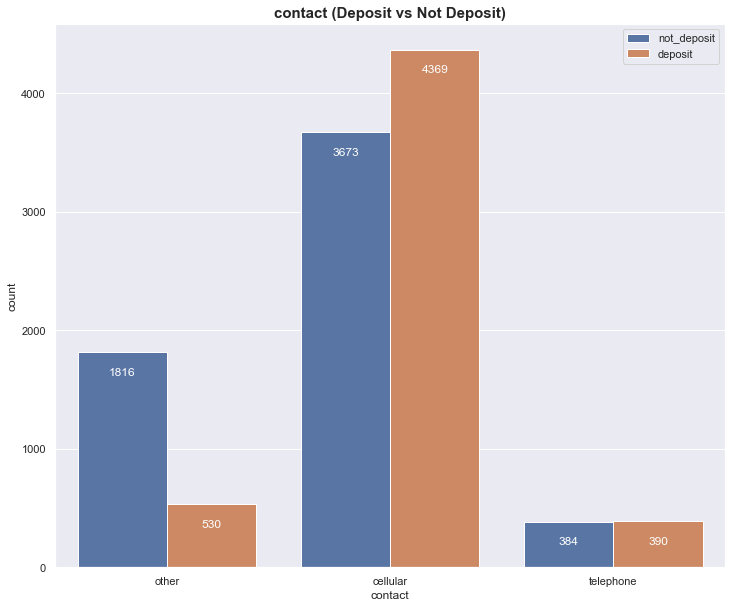

In [54]:
fig5 = plt.figure(figsize=(12,10))
plt.title('contact (Deposit vs Not Deposit)', fontsize=15, fontweight='bold')

ax_d = sns.countplot(df['contact'], hue=df['depositbin'])
for d in ax_d.patches:
    ax_d.annotate(format(d.get_height(), '.0f'), (d.get_x() + d.get_width() / 2., d.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, -20), fontsize=12, color='white', textcoords = 'offset points')
plt.legend(['not_deposit', 'deposit'])
plt.show()

In [55]:
feat = "contact"

valdep = dtdep.loc[:,feat].value_counts()
valnotdep = dtnotdep.loc[:, feat].value_counts()

contact = pd.DataFrame()
contact["notDeposit"] = valnotdep
contact["Deposit"] = valdep
contact["%Deposit"] = round((valdep * 100 / (valdep + valnotdep)), 2)
contact

,notDeposit,Deposit,%Deposit
cellular,3673,4369,54.33
other,1816,530,22.59
telephone,384,390,50.39


In [56]:
contact_cor = correlation_ratio(df['contact'], df['depositbin'])

### Month x Deposit

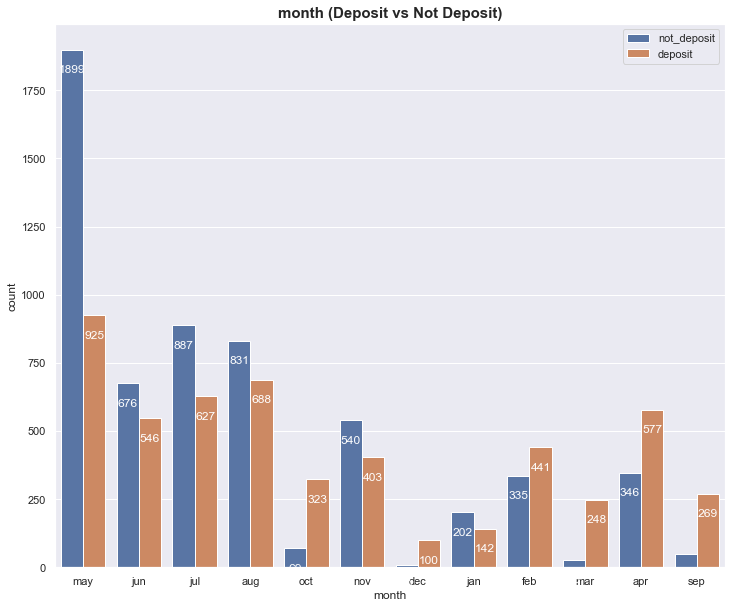

In [57]:
fig5 = plt.figure(figsize=(12,10))
plt.title('month (Deposit vs Not Deposit)', fontsize=15, fontweight='bold')

ax_d = sns.countplot(df['month'], hue=df['depositbin'])
for d in ax_d.patches:
    ax_d.annotate(format(d.get_height(), '.0f'), (d.get_x() + d.get_width() / 2., d.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, -20), fontsize=12, color='white', textcoords = 'offset points')
plt.legend(['not_deposit', 'deposit'])
plt.show()

In [58]:
feat = "month"

valdep = dtdep.loc[:,feat].value_counts()
valnotdep = dtnotdep.loc[:, feat].value_counts()

month = pd.DataFrame()
month["notDeposit"] = valnotdep
month["Deposit"] = valdep
month["%Deposit"] = round((valdep * 100 / (valdep + valnotdep)), 2)
month

,notDeposit,Deposit,%Deposit
may,1899,925,32.75
jul,887,627,41.41
aug,831,688,45.29
jun,676,546,44.68
nov,540,403,42.74
apr,346,577,62.51
feb,335,441,56.83
jan,202,142,41.28
oct,69,323,82.40
sep,50,269,84.33


In [59]:
month_cor = correlation_ratio(df['month'], df['depositbin'])

### pOutcome x Deposit

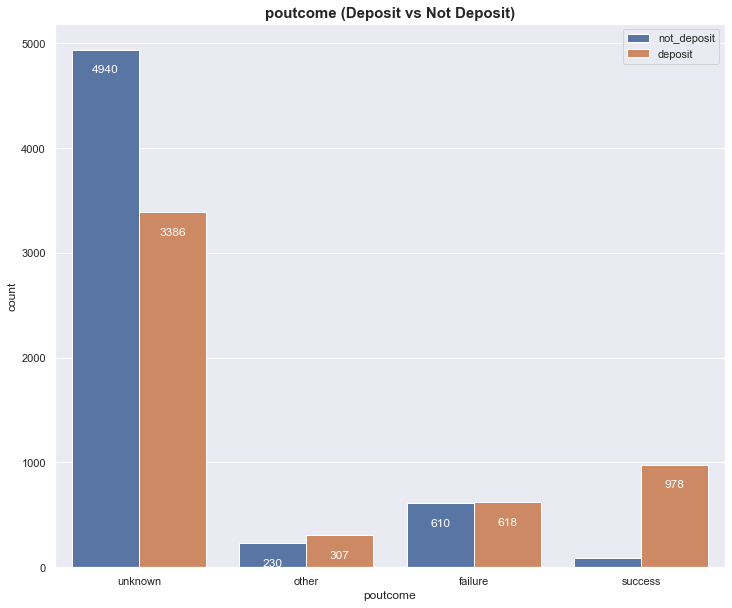

In [60]:
fig5 = plt.figure(figsize=(12,10))
plt.title('poutcome (Deposit vs Not Deposit)', fontsize=15, fontweight='bold')

ax_d = sns.countplot(df['poutcome'], hue=df['depositbin'])
for d in ax_d.patches:
    ax_d.annotate(format(d.get_height(), '.0f'), (d.get_x() + d.get_width() / 2., d.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, -20), fontsize=12, color='white', textcoords = 'offset points')
plt.legend(['not_deposit', 'deposit'])
plt.show()

In [61]:
feat = "poutcome"

valdep = dtdep.loc[:,feat].value_counts()
valnotdep = dtnotdep.loc[:, feat].value_counts()

poutcome = pd.DataFrame()
poutcome["notDeposit"] = valnotdep
poutcome["Deposit"] = valdep
poutcome["%Deposit"] = round((valdep * 100 / (valdep + valnotdep)), 2)
poutcome

,notDeposit,Deposit,%Deposit
unknown,4940,3386,40.67
failure,610,618,50.33
other,230,307,57.17
success,93,978,91.32


In [62]:
pout_cor = correlation_ratio(df['poutcome'], df['depositbin'])

### Correlation

In [63]:
dfenc = df.drop(['deposit'], axis = 1)

In [64]:
var=["job", "marital", "education", "default", "month", "housing", "loan", "contact",  "poutcome"]
labelencoder = LabelEncoder()
for i in var:
    dfenc[i]= dfenc[i].astype("str")

for i in var:
    dfenc[i] = labelencoder.fit_transform(dfenc[i])

dfenc.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,depositbin
0,59,0,1,2,0,2343,1,0,1,5,8,1042,1,-1,0,3,1
1,56,0,1,2,0,45,0,0,1,5,8,1467,1,-1,0,3,1
2,41,10,1,2,0,1270,1,0,1,5,8,1389,1,-1,0,3,1
3,55,8,1,2,0,2476,1,0,1,5,8,579,1,-1,0,3,1
4,54,0,1,3,0,184,0,0,1,5,8,673,2,-1,0,3,1


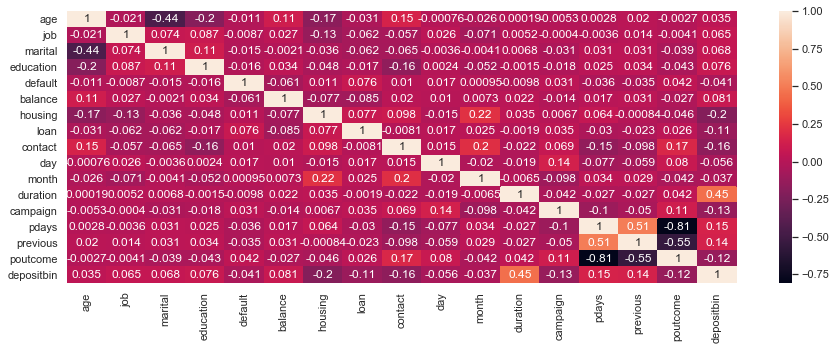

In [65]:
plt.figure(figsize = (15, 5))
sns.heatmap(dfenc.corr(method = 'pearson'), annot = True)

plt.show()

In [66]:
dfenc.corr()['depositbin'].sort_values(ascending=False)

depositbin    1.000000
duration      0.451919
pdays         0.151593
previous      0.139867
balance       0.081129
education     0.075583
marital       0.067610
job           0.065343
age           0.034901
month        -0.037121
default      -0.040680
day          -0.056326
loan         -0.110580
poutcome     -0.122369
campaign     -0.128081
contact      -0.158744
housing      -0.203888
Name: depositbin, dtype: float64

In [67]:
print(f'Correlation between Job and Deposit : {job_cor}'+'\n'
      f'Correlation between Marital and Deposit : {mar_cor}'+'\n'
      f'Correlation between Education and Deposit : {edu_cor}'+'\n'
      f'Correlation between Default and Deposit : {defa_cor}'+'\n'
      f'Correlation between Housing and Deposit : {housing_cor}'+'\n'
      f'Correlation between Loan and Deposit : {loan_cor}'+'\n'
      f'Correlation between Contact and Deposit : {contact_cor}'+'\n'
      f'Correlation between Month and Deposit : {month_cor}'+'\n'
      f'Correlation between poutcome and Deposit : {pout_cor}')

Correlation between Job and Deposit : 0.18404249757217803
Correlation between Marital and Deposit : 0.09908348866599889
Correlation between Education and Deposit : 0.10487579776833521
Correlation between Default and Deposit : 0.040680087081149674
Correlation between Housing and Deposit : 0.2038877493378849
Correlation between Loan and Deposit : 0.11057998365404782
Correlation between Contact and Deposit : 0.2569037238879407
Correlation between Month and Deposit : 0.3062355171617707
Correlation between poutcome and Deposit : 0.3000083287659087


since all off categorical data, we could see for all above. Features poutcome is the one i don't get it at all, since unknown have a lot of data rather than others, i would like to drop pdays

drop features we are not using

In [68]:
datadrop = df.drop(['day', 'pdays', 'previous', 'poutcome','deposit'], axis = 1)
datadrop.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,depositbin
0,59,admin.,married,secondary,no,2343,yes,no,other,may,1042,1,1
1,56,admin.,married,secondary,no,45,no,no,other,may,1467,1,1
2,41,technician,married,secondary,no,1270,yes,no,other,may,1389,1,1
3,55,services,married,secondary,no,2476,yes,no,other,may,579,1,1
4,54,admin.,married,tertiary,no,184,no,no,other,may,673,2,1


In [69]:
datadrop.to_csv("df_Dummy.csv", index=False)

In [70]:
datadrop['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
other              70
Name: job, dtype: int64